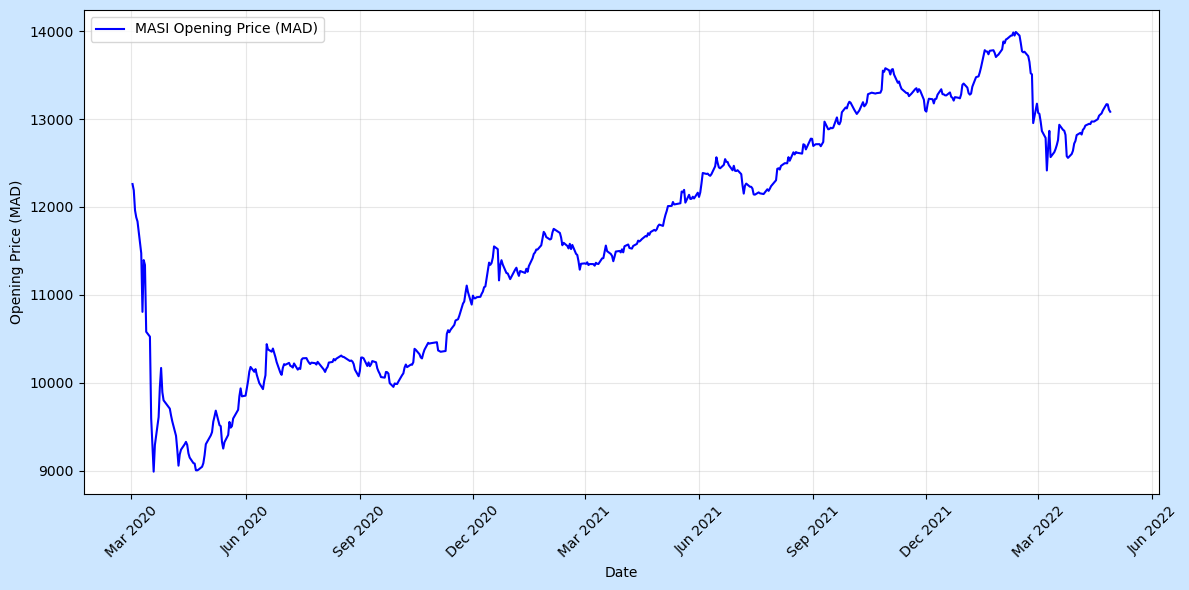

C:\Anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


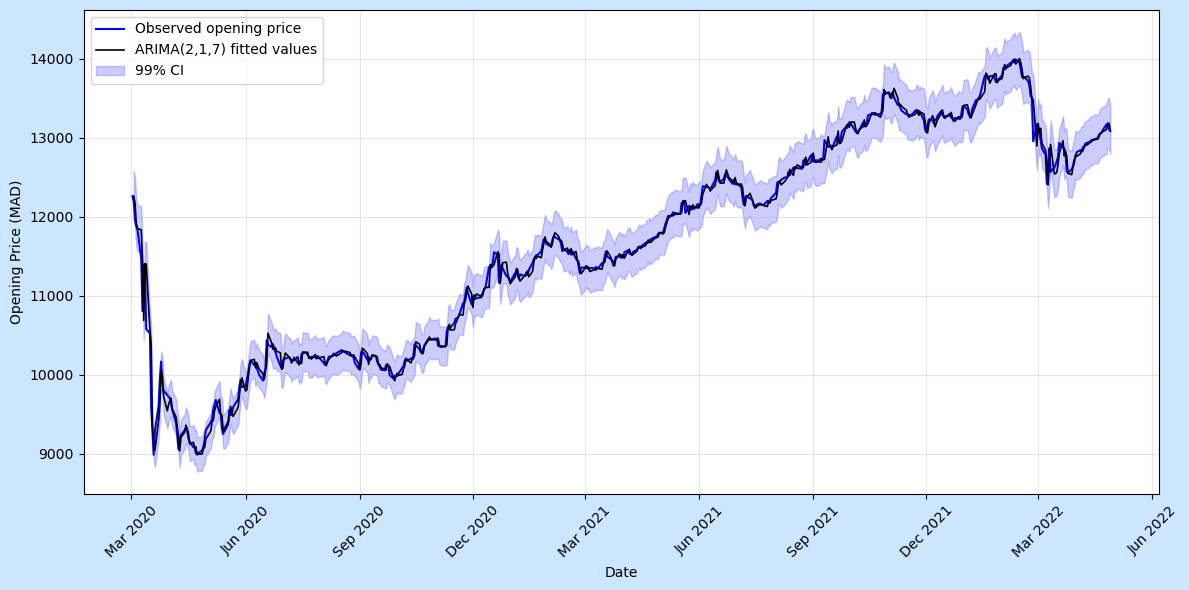

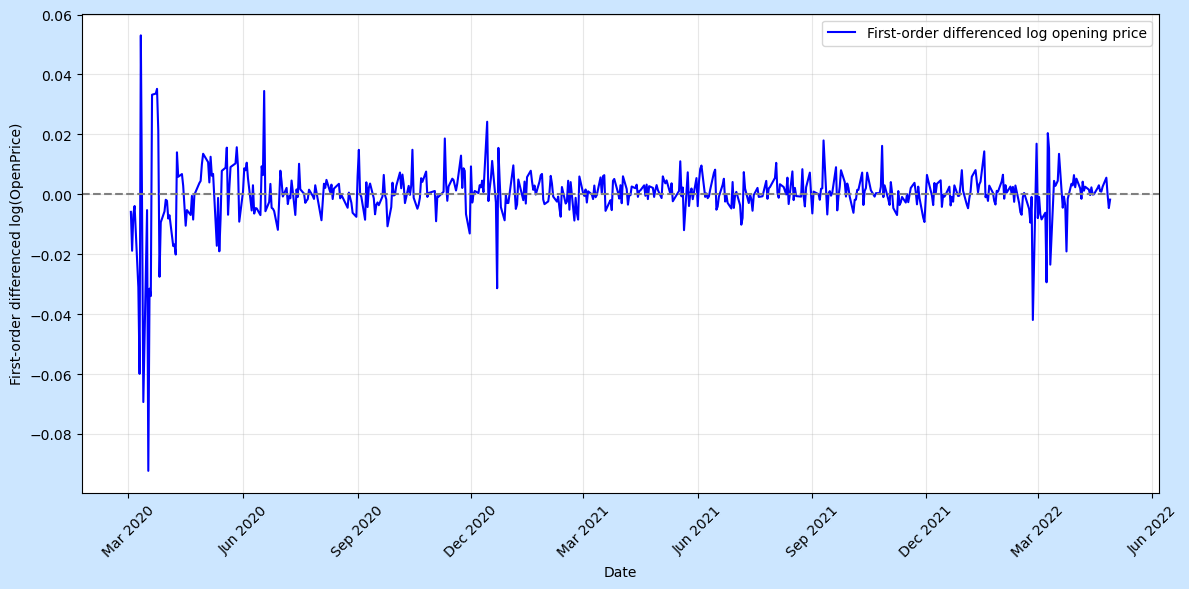

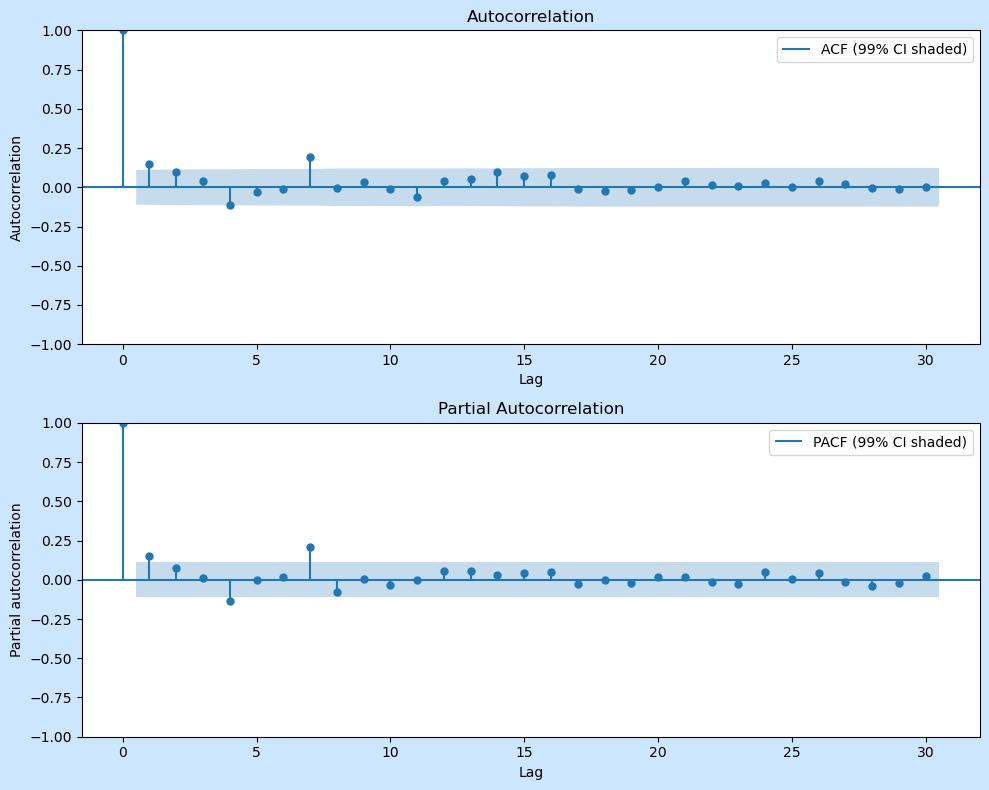

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


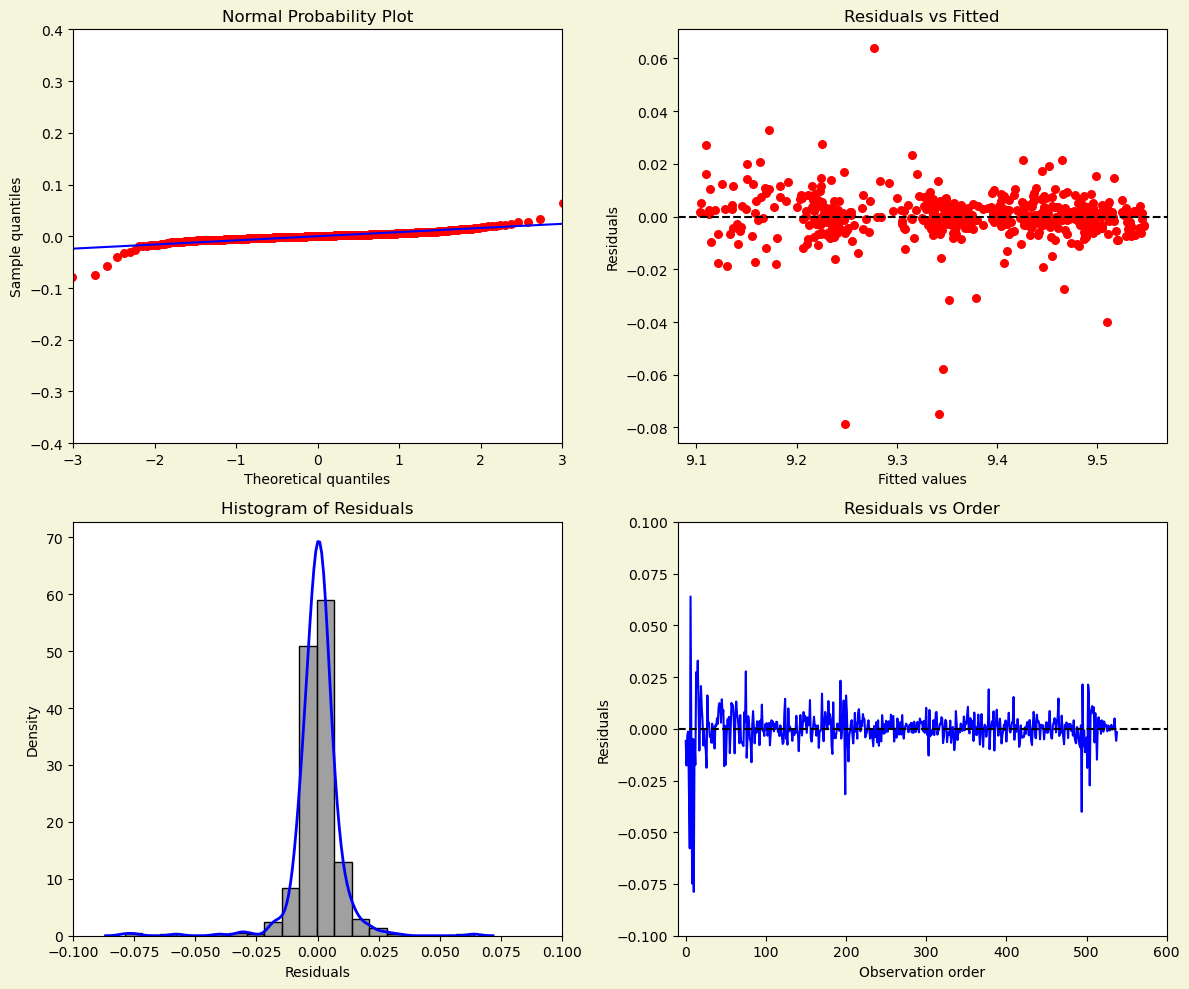

In [1]:
# ==========================================================
# Libraries
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats

# ==========================================================
# Load and prepare MASI data
# ==========================================================
df = pd.read_csv("masi.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Sort ascending (past -> present)
df = df.sort_values("Date").reset_index(drop=True)

# Keep only Date + Opening Price
masi = df[["Date", "Open"]].copy()
masi.rename(columns={"Open": "OpenPrice"}, inplace=True)

# Ensure numeric (strip commas if present)
masi["OpenPrice"] = (
    masi["OpenPrice"].astype(str).str.replace(",", "", regex=False).astype(float)
)

# Log transform and first-order differencing
masi["LogOpen"] = np.log1p(masi["OpenPrice"])
masi["Diff1_LogOpen"] = masi["LogOpen"].diff()
diff_series = masi.dropna(subset=["Diff1_LogOpen"])

# Style variables
outer_bg = "#cce6ff"   # light blue background
inner_bg = "white"     # white plot panels

# ==========================================================
# 1. Original MASI opening price (time series)
# ==========================================================
fig, ax = plt.subplots(figsize=(12,6))
fig.patch.set_facecolor(outer_bg)
ax.set_facecolor(inner_bg)

ax.plot(masi["Date"], masi["OpenPrice"], color="blue", linewidth=1.5,
        label="MASI Opening Price (MAD)")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

ax.set_xlabel("Date")
ax.set_ylabel("Opening Price (MAD)")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("masi_timeseries.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()

# ==========================================================
# 2. Time series with ARIMA(2,1,7) fitted values + 99% CI
# ==========================================================
# Fit ARIMA on log scale with first differencing
model = ARIMA(masi["LogOpen"], order=(2,1,7))
fit = model.fit()

# Drop burn-in observations (where ARIMA is unstable)
start_idx = fit.loglikelihood_burn
pred = fit.get_prediction(start=start_idx, end=len(masi)-1)
pred_mean_log = pred.predicted_mean
pred_ci_log = pred.conf_int(alpha=0.01)  # 99% CI

# Back-transform to original scale
pred_mean = np.expm1(pred_mean_log)
pred_ci = np.expm1(pred_ci_log)

fig, ax = plt.subplots(figsize=(12,6))
fig.patch.set_facecolor(outer_bg)
ax.set_facecolor(inner_bg)

ax.plot(masi["Date"], masi["OpenPrice"], color="blue", linewidth=1.5,
        label="Observed opening price")
ax.plot(masi["Date"].iloc[start_idx:], pred_mean, color="black", linewidth=1.2,
        label="ARIMA(2,1,7) fitted values")
ax.fill_between(masi["Date"].iloc[start_idx:], pred_ci.iloc[:,0], pred_ci.iloc[:,1],
                color="blue", alpha=0.2, label="99% CI")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

ax.set_xlabel("Date")
ax.set_ylabel("Opening Price (MAD)")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("masi_with_ci.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()

# ==========================================================
# 3. First-order differenced log-transformed series
# ==========================================================
fig, ax = plt.subplots(figsize=(12,6))
fig.patch.set_facecolor(outer_bg)
ax.set_facecolor(inner_bg)

ax.plot(diff_series["Date"], diff_series["Diff1_LogOpen"], color="blue", linewidth=1.5,
        label="First-order differenced log opening price")
ax.axhline(0, color="gray", linestyle="--")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45)

ax.set_xlabel("Date")
ax.set_ylabel("First-order differenced log(OpenPrice)")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("masi_first_order_diff.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()

# ==========================================================
# 4. ACF and PACF plots (99% CI, lag=30)
# ==========================================================
fig, axes = plt.subplots(2, 1, figsize=(10,8))
fig.patch.set_facecolor(outer_bg)

for ax in axes:
    ax.set_facecolor(inner_bg)

plot_acf(diff_series["Diff1_LogOpen"].dropna(), lags=30, ax=axes[0], alpha=0.01)
axes[0].set_ylabel("Autocorrelation")
axes[0].set_xlabel("Lag")
axes[0].legend(["ACF (99% CI shaded)"])

plot_pacf(diff_series["Diff1_LogOpen"].dropna(), lags=30, ax=axes[1], alpha=0.01, method="ywm")
axes[1].set_ylabel("Partial autocorrelation")
axes[1].set_xlabel("Lag")
axes[1].legend(["PACF (99% CI shaded)"])

plt.tight_layout()
plt.savefig("masi_acf_pacf.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()

# ==========================================================
# 5. Residual diagnostics (2x2 panel) with cleaned residuals
# ==========================================================
residuals = fit.resid[start_idx:]  # drop unstable early values
residuals_clean = residuals[np.abs(residuals) < 1]  # remove outliers like 9.41
fitted_vals = fit.fittedvalues[start_idx:]

fig, axes = plt.subplots(2, 2, figsize=(12,10))
fig.patch.set_facecolor("#f5f5dc")

for ax in axes.flatten():
    ax.set_facecolor("white")

# --- Q-Q Plot ---
osm, osr = stats.probplot(residuals_clean, dist="norm")[:2]
theoretical_q = osm[0]
sample_q = osm[1]
axes[0,0].scatter(theoretical_q, sample_q, color="red", s=30)
slope, intercept, *_ = stats.linregress(theoretical_q, sample_q)
axes[0,0].plot(theoretical_q, intercept + slope*theoretical_q, color="blue")
axes[0,0].set_xlim(-3, 3)
axes[0,0].set_ylim(-0.4, 0.4)
axes[0,0].set_xlabel("Theoretical quantiles")
axes[0,0].set_ylabel("Sample quantiles")
axes[0,0].set_title("Normal Probability Plot")

# --- Residuals vs Fitted ---
axes[0,1].scatter(fitted_vals, residuals_clean, color="red", s=30)
axes[0,1].axhline(0, color="black", linestyle="--")
axes[0,1].set_xlabel("Fitted values")
axes[0,1].set_ylabel("Residuals")
axes[0,1].set_title("Residuals vs Fitted")

# --- Histogram + KDE ---
sns.histplot(residuals_clean, bins=20, color="gray", stat="density", ax=axes[1,0])
sns.kdeplot(residuals_clean, color="blue", ax=axes[1,0], linewidth=2)
axes[1,0].set_xlim(-0.1, 0.1)
axes[1,0].set_xlabel("Residuals")
axes[1,0].set_ylabel("Density")
axes[1,0].set_title("Histogram of Residuals")

# --- Residuals vs Order ---
axes[1,1].plot(range(len(residuals_clean)), residuals_clean, color="blue")
axes[1,1].axhline(0, color="black", linestyle="--")
axes[1,1].set_xlim(-10, 600)   # add padding before 0
axes[1,1].set_ylim(-0.1, 0.1)
axes[1,1].set_xlabel("Observation order")
axes[1,1].set_ylabel("Residuals")
axes[1,1].set_title("Residuals vs Order")

plt.tight_layout()
plt.savefig("masi_residual_diagnostics.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()


Number of observations in MASI series: 540
Planned number of rolling iterations: 288
Starting rolling loop...
  Iteration 1/288, end index = 250
  Iteration 51/288, end index = 300
  Iteration 101/288, end index = 350
  Iteration 151/288, end index = 400
  Iteration 201/288, end index = 450
  Iteration 251/288, end index = 500
Finished rolling loop.
Number of rolling forecasts actually produced: 288

Rolling 3-day-ahead evaluation for MASI ARIMA(2,1,7)
RMSE: 154.6410
MAE:  114.2513
MAPE: 0.89%


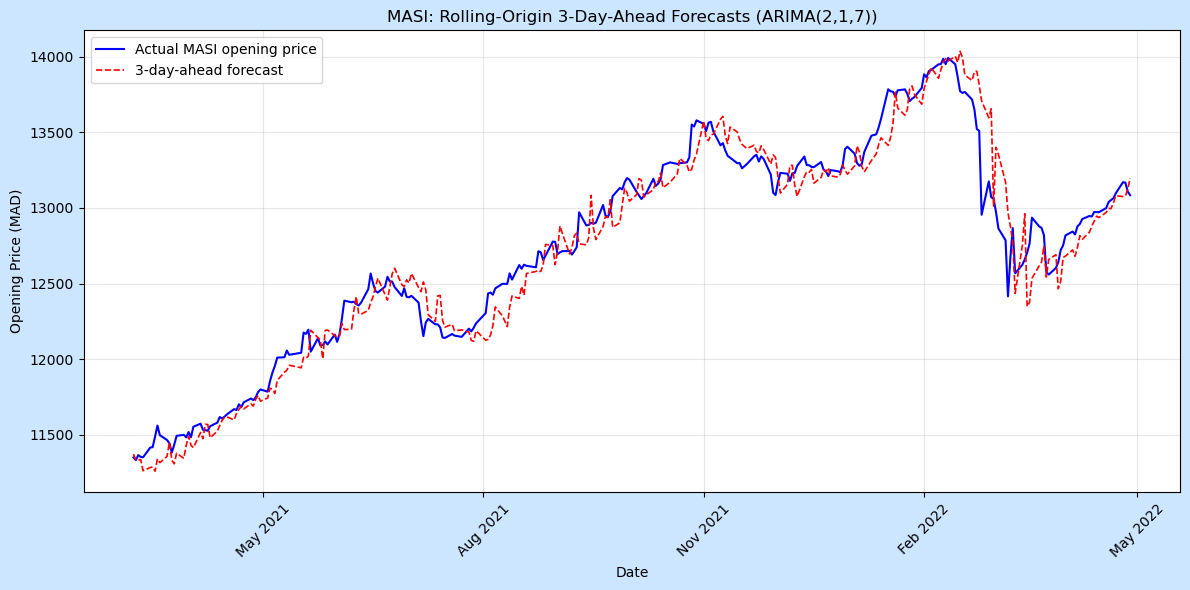

In [3]:
# ==========================================================
# 6. Rolling-origin cross-validation (3-day-ahead forecasts)
# ==========================================================
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

# 3-day horizon, ~1 trading year as minimum training size
horizon = 3
min_train_size = 250

# Series from your existing MASI DataFrame
y = masi["OpenPrice"].values.astype(float)
log_y = masi["LogOpen"].values.astype(float)

n = len(y)
print("Number of observations in MASI series:", n)

forecast_3d = []
actual_3d = []
forecast_dates = []

# ---- DEBUG: if this prints 0, the loop won't run
num_iterations = max(n - horizon + 1 - min_train_size, 0)
print("Planned number of rolling iterations:", num_iterations)

# Rolling-origin loop
print("Starting rolling loop...")
for i, end in enumerate(range(min_train_size, n - horizon + 1)):
    # Debug print every 50 iterations so you see progress
    if i % 50 == 0:
        print(f"  Iteration {i+1}/{num_iterations}, end index = {end}")

    train_series = log_y[:end]

    # Fit ARIMA(2,1,7) on log scale
    model_cv = ARIMA(train_series, order=(2,1,7),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
    fit_cv = model_cv.fit()

    # Forecast 3 days ahead on log scale
    fcst_log = fit_cv.forecast(steps=horizon)

    # Take the 3rd day and back-transform
    fcst_val = np.expm1(fcst_log[-1])

    # Matching actual value and date
    idx_actual = end + horizon - 1
    actual_val = y[idx_actual]
    date_val = masi["Date"].iloc[idx_actual]

    forecast_3d.append(fcst_val)
    actual_3d.append(actual_val)
    forecast_dates.append(date_val)

print("Finished rolling loop.")

forecast_3d = np.array(forecast_3d)
actual_3d = np.array(actual_3d)

print("Number of rolling forecasts actually produced:", len(forecast_3d))

# Safety check: if something went wrong
if len(forecast_3d) == 0:
    print("No forecasts were produced – check min_train_size / horizon.")
else:
    # ---- Metrics ----
    mask = actual_3d > 0

    rmse_3d = np.sqrt(np.mean((actual_3d - forecast_3d) ** 2))
    mae_3d  = np.mean(np.abs(actual_3d - forecast_3d))
    mape_3d = np.mean(
        np.abs((actual_3d[mask] - forecast_3d[mask]) / actual_3d[mask])
    ) * 100

    print("\nRolling 3-day-ahead evaluation for MASI ARIMA(2,1,7)")
    print(f"RMSE: {rmse_3d:.4f}")
    print(f"MAE:  {mae_3d:.4f}")
    print(f"MAPE: {mape_3d:.2f}%")

    # ---- Save results ----
    rolling_masi_results = pd.DataFrame({
        "Date": forecast_dates,
        "Actual_OpenPrice": actual_3d,
        "Forecast_3day_Ahead": forecast_3d
    })
    rolling_masi_results.to_excel("rolling_3day_arima_masi.xlsx", index=False)

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(12,6))
    fig.patch.set_facecolor(outer_bg)
    ax.set_facecolor(inner_bg)

    ax.plot(rolling_masi_results["Date"],
            rolling_masi_results["Actual_OpenPrice"],
            color="blue", linewidth=1.5, label="Actual MASI opening price")
    ax.plot(rolling_masi_results["Date"],
            rolling_masi_results["Forecast_3day_Ahead"],
            color="red", linestyle="--", linewidth=1.2,
            label="3-day-ahead forecast")

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.xticks(rotation=45)

    ax.set_xlabel("Date")
    ax.set_ylabel("Opening Price (MAD)")
    ax.set_title("MASI: Rolling-Origin 3-Day-Ahead Forecasts (ARIMA(2,1,7))")
    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("masi_rolling_3day_forecast_plot.png", dpi=300,
                facecolor=fig.get_facecolor())
    plt.show()


In [4]:
min_train_size = 400   # start later
n = len(y)
test_end = 300         # only run first 50 iterations for a quick check

for end in range(min_train_size, min(min_train_size + test_end, n - horizon + 1)):
    ...
